# Libraries

In [28]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
# from google.colab import files

# List of all links for race results and starting grid per year and country

In [29]:
country_URLs = []
for year in range(2012,2022):
    
    domain = 'https://www.formula1.com'
    URL = f'{domain}/en/results.html/{year}/races.html'
    html = requests.get(URL)
    soup = BeautifulSoup(html.text, "html.parser")

    country_div = soup.find_all("div", class_="resultsarchive-filter-wrap")[2]

    for a in country_div.find_all("a", class_="resultsarchive-filter-item-link"):
        url = f'{domain}{a["href"]}'
        country_URLs.append((a.text.replace("\n",""), year, url, url.replace("race-result","starting-grid")))
        
    country_URLs.pop(0)
    
country_URLs = [x for x in country_URLs if x[0] != 'All']

# Race Results Data
### List of List ===> [[country, year, race_result_pos, driver_no, driver_name+initials, car, laps, time_or_retired, pts]...]

In [30]:
rr_list = []
    
for country in country_URLs:
    html = requests.get(country[2])
    soup = BeautifulSoup(html.text, "html.parser")
    
    rows = soup.find('tbody').find_all('tr')

    for r in rows:
        data = r.find_all('td')[1:-1]

        row = []
        row.append(country[0])
        row.append(country[1])
        for d in data:
            row.append(d.text)
        rr_list.append(row)
# rr_list

# Race Results Data Frame

In [31]:
rr_df = pd.DataFrame()
rr_df["Country"] = [x[0] for x in rr_list]
rr_df["Year"] = [x[1] for x in rr_list]
rr_df["Race_Result_Pos"] = [x[2] for x in rr_list]
rr_df["Driver_No"] = [x[3] for x in rr_list]
rr_df["Driver_Name"] = [" ".join(x[4].split("\n")[1:-2]) for x in rr_list]
rr_df["Driver_Initials"] = [" ".join(x[4].split("\n")[-2:-1]) for x in rr_list]
rr_df["Car_Name"] = [x[5] for x in rr_list]
rr_df["Laps"] = [x[6] for x in rr_list]
rr_df["Time_or_Retired"] = [x[7] for x in rr_list]
rr_df["Points"] = [x[8] for x in rr_list]

rr_df.head() 

,Country,Year,Race_Result_Pos,Driver_No,Driver_Name,Driver_Initials,Car_Name,Laps,Time_or_Retired,Points
0,Germany,2012,1,5,Fernando Alonso,ALO,Ferrari,67,1:31:05.862,25
1,Germany,2012,2,3,Jenson Button,BUT,McLaren Mercedes,67,+6.949s,18
2,Germany,2012,3,9,Kimi RÃ¤ikkÃ¶nen,RAI,Lotus Renault,67,+16.409s,15
3,Germany,2012,4,14,Kamui Kobayashi,KOB,Sauber Ferrari,67,+21.925s,12
4,Germany,2012,5,1,Sebastian Vettel,VET,Red Bull Racing Renault,67,+23.732s,10


# Race Result Data Frame Cleaning

In [32]:
birthyear_map_rr = {'Fernando Alonso': 1981, 'Sebastian Vettel': 1987, 'Michael Schumacher': 1969, 'Nico Hulkenberg': 1987, 'Pastor Maldonado': 1985, 'Jenson Button': 1980, 'Lewis Hamilton': 1985, 'Mark Webber': 1976, 
                'Paul di Resta': 1986, 'Kimi RÃ¤ikkÃ¶nen': 1979,'Daniel Ricciardo': 1989,'Kamui Kobayashi': 1986,'Felipe Massa': 1981,'Bruno Senna': 1983,'Jean-Eric Vergne': 1990,'Heikki Kovalainen': 1981,
                'Sergio Perez': 1990,'Vitaly Petrov': 1984,'Romain Grosjean': 1986,'Charles Pic': 1990,'Nico Rosberg': 1985,'Timo Glock': 1982,'Pedro de la Rosa': 1971,'Narain Karthikeyan': 1977,"Jerome d'Ambrosio": 1985,
                'Adrian Sutil': 1983,'Valtteri Bottas': 1989,'Esteban Gutierrez ': 1991,'Jules Bianchi': 1989,'Max Chilton': 1991,'Giedo van der Garde': 1985,'Kevin Magnussen': 1992,'Daniil Kvyat': 1994,
                'Marcus Ericsson': 1990,'Andre Lotterer': 1981,'Will Stevens': 1991,'Carlos Sainz': 1994,'Felipe Nasr': 1992,'Max Verstappen': 1997,'Roberto Merhi': 1991,'Alexander Rossi': 1991,
                'Jolyon Palmer': 1991,'Pascal Wehrlein': 1994,'Rio Haryanto': 1993,'Stoffel Vandoorne': 1992,'Esteban Ocon': 1996,'Antonio Giovinazzi': 1993,'Lance Stroll': 1998,'Pierre Gasly': 1996,
                'Brendon Hartley': 1989,'Charles Leclerc': 1997,'Sergey Sirotkin': 1995,'Lando Norris': 1999,'Alexander Albon': 1996,'George Russell': 1998,'Robert Kubica': 1984,'Nicholas Latifi': 1995,
                'Jack Aitken': 1995,'Pietro Fittipaldi': 1996,'Yuki Tsunoda': 2000,'Mick Schumacher': 1999,'Nikita Mazepin': 1999}

In [33]:
# Changing Column data types + Cleaning and adding additional data (birth year, age) + fixing incorrect country names + driver names

# Driver Names and Birth Year
rr_df['Birth_Year'] = rr_df['Driver_Name'].map(birthyear_map_rr)

#Changing column data types   #change time column to datetime!! 
# rr_df = rr_df.astype({'Year':'int', 'Driver_No':'int', 'Birth_Year': 'int'}) #int types complete for rr // 'Race_Result_Pos':'int', 'Laps':'int', 'Points':'float' --> have values that are not numbers, or empty
rr_df['Age'] = rr_df['Year'] - rr_df['Birth_Year'] #get driver age at each year 

# Update Kimi Raikkonen's name 
rr_df['Driver_Name'] = rr_df['Driver_Name'].map({'Kimi RÃ¤ikkÃ¶nen': 'Kimi Raikkonen'}).fillna(rr_df['Driver_Name'])

# Update incorrect country names
country_update = {'70th Anniversary': 'Great Britain', 
                  'Eifel': 'Germany', 'Europe': 'Spain', 
                  "United States  ": "United States", 
                  "United States ": "United States"}

rr_df['Country'] = rr_df['Country'].map(country_update).fillna(rr_df['Country'])

#Additional cleaning:
rr_df['Race_Result_Pos'] = rr_df['Race_Result_Pos'].replace(['NC','EX','DQ'],'DNF')
rr_df['Laps'] = rr_df['Laps'].fillna(0)
rr_df['Laps'] = rr_df['Laps'].replace(['',0])
rr_df["Driver_No"] = pd.to_numeric(rr_df["Driver_No"])

# rr_df["Race_Result_Pos"] = pd.to_numeric(rr_df["Race_Result_Pos"])
rr_df["Laps"] = pd.to_numeric(rr_df["Laps"])
rr_df["Points"] = pd.to_numeric(rr_df["Points"])
rr_df["Year"] = pd.to_numeric(rr_df["Year"])


# Starting Grid Data
### [[country, year, starting_grid_pos, driver_no, driver_name+initials, car, time]...]



In [34]:
sg_list = []
    
for country in country_URLs:
    html = requests.get(country[3])
    soup = BeautifulSoup(html.text, "html.parser")
    
    rows = soup.find('tbody').find_all('tr')

    for r in rows:
        data = r.find_all('td')[1:-1]

        row = []
        row.append(country[0])
        row.append(country[1])
        for d in data:
            row.append(d.text)
        sg_list.append(row)

# sg_list

# Starting Grid Data Cleaning

In [35]:
# For 2021 UK, Brazil, and Italy they don't have data on starting-grid time
# Get UK, Brazil, Italy info!! 

for x in sg_list:
    if len(x) != 7:
        x.append('DNR')
[x for x in sg_list if len(x) != 7]

[]

In [36]:
no_times = [["Great Britain", "Lewis Hamilton", "1:26.134"], ["Great Britain", "Max Verstappen", "1:26.209"], ["Great Britain", "Valtteri Bottas", "1:26.328"], ["Great Britain", "Charles Leclerc", "1:26.828"], ["Great Britain", "Sergio Perez", "1:26.844"], ["Great Britain", "Lando Norris", "1:26.897"], ["Great Britain", "Daniel Ricciardo", "1:26.899"], ["Great Britain", "George Russell", "1:26.971"], ["Great Britain", "Carlos Sainz", "1:27.007"], ["Great Britain", "Sebastian Vettel", "1:27.179"], ["Great Britain", "Fernando Alonso", "1:27.245"], ["Great Britain", "Pierre Gasly", "1:27.273"], ["Great Britain", "Esteban Ocon", "1:27.340"], ["Great Britain", "Antonio Giovinazzi", "1:27.617"], ["Great Britain", "Lance Stroll", "1:27.665"], ["Great Britain", "Yuki Tsunoda", "1:28.043"], ["Great Britain", "Kimi Räikkönen", "1:28.062"], ["Great Britain", "Nicholas Latifi", "1:28.254"], ["Great Britain", "Mick Schumacher", "1:28.738"], ["Great Britain", "Nikita Mazepin", "1:29.051"], ["Italy", "Valtteri Bottas", "1:19.555"], ["Italy", "Lewis Hamilton", "1:19.651"], ["Italy", "Max Verstappen", "1:19.966"], ["Italy", "Lando Norris", "1:19.989"], ["Italy", "Daniel Ricciardo", "1:19.995"], ["Italy", "Pierre Gasly", "1:20.260"], ["Italy", "Carlos Sainz", "1:20.462"], ["Italy", "Charles Leclerc", "1:20.510"], ["Italy", "Sergio Perez", "1:20.611"], ["Italy", "Antonio Giovinazzi", "1:20.808"], ["Italy", "Sebastian Vettel", "1:20.913"], ["Italy", "Lance Stroll", "1:21.020"], ["Italy", "Fernando Alonso", "1:21.069"], ["Italy", "Esteban Ocon", "1:21.103"], ["Italy", "George Russell", "1:21.392"], ["Italy", "Nicholas Latifi", "1:21.925"], ["Italy", "Yuki Tsunoda", "1:21.973"], ["Italy", "Mick Schumacher", "1:22.248"], ["Italy", "Robert Kubica", "1:22.530"], ["Italy", "Nikita Mazepin", "1:22.716"], ["Brazil", "Lewis Hamilton", "1:07.934"], ["Brazil", "Max Verstappen", "1:08.372"], ["Brazil", "Valtteri Bottas", "1:08.469"], ["Brazil", "Sergio Perez", "1:08.483"], ["Brazil", "Pierre Gasly", "1:08.777"], ["Brazil", "Carlos Sainz", "1:08.826"], ["Brazil", "Charles Leclerc", "1:08.960"], ["Brazil", "Lando Norris", "1:08.980"], ["Brazil", "Daniel Ricciardo", "1:09.039"], ["Brazil", "Fernando Alonso", "1:09.113"], ["Brazil", "Esteban Ocon", "1:09.189"], ["Brazil", "Sebastian Vettel", "1:09.399"], ["Brazil", "Yuki Tsunoda", "1:09.483"], ["Brazil", "Kimi Räikkönen", "1:09.503"], ["Brazil", "Antonio Giovinazzi", "1:10.227"], ["Brazil", "Lance Stroll", "1:09.663"], ["Brazil", "Nicholas Latifi", "1:09.897"], ["Brazil", "George Russell", "1:09.953"], ["Brazil", "Mick Schumacher", "1:10.329"], ["Brazil", "Nikita Mazepin", "1:10.589"]]
for n in no_times:
    for x in sg_list:
        if " ".join(x[4].split("\n")[1:-2]) == n[1] and x[0] == n[0] and x[1] == 2021:
            x[6] = n[2]
            print(x)

['Great Britain', 2021, '2', '44', '\nLewis\nHamilton\nHAM\n', 'Mercedes', '1:26.134']
['Great Britain', 2021, '1', '33', '\nMax\nVerstappen\nVER\n', 'Red Bull Racing Honda', '1:26.209']
['Great Britain', 2021, '3', '77', '\nValtteri\nBottas\nBOT\n', 'Mercedes', '1:26.328']
['Great Britain', 2021, '4', '16', '\nCharles\nLeclerc\nLEC\n', 'Ferrari', '1:26.828']
['Great Britain', 2021, '20', '11', '\nSergio\nPerez\nPER\n', 'Red Bull Racing Honda', '1:26.844']
['Great Britain', 2021, '5', '4', '\nLando\nNorris\nNOR\n', 'McLaren Mercedes', '1:26.897']
['Great Britain', 2021, '6', '3', '\nDaniel\nRicciardo\nRIC\n', 'McLaren Mercedes', '1:26.899']
['Great Britain', 2021, '12', '63', '\nGeorge\nRussell\nRUS\n', 'Williams Mercedes', '1:26.971']
['Great Britain', 2021, '10', '55', '\nCarlos\nSainz\nSAI\n', 'Ferrari', '1:27.007']
['Great Britain', 2021, '8', '5', '\nSebastian\nVettel\nVET\n', 'Aston Martin Mercedes', '1:27.179']
['Great Britain', 2021, '7', '14', '\nFernando\nAlonso\nALO\n', 'Alp

# Starting Grid Data Frame


In [37]:
sg_df = pd.DataFrame()
sg_df["Country"] = [x[0] for x in sg_list]
sg_df["Year"] = [x[1] for x in sg_list]
sg_df["Starting_Grid_Pos"] = [x[2] for x in sg_list]
sg_df["Driver_No"] = [x[3] for x in sg_list]
sg_df["Driver_Name"] = [" ".join(x[4].split("\n")[1:-2]) for x in sg_list]
sg_df["Driver_Initials"] = [" ".join(x[4].split("\n")[-2:-1]) for x in sg_list]
sg_df["Car_Name"] = [x[5] for x in sg_list]
sg_df["QualifyTime"] = [x[6] for x in sg_list]

sg_df.head()

,Country,Year,Starting_Grid_Pos,Driver_No,Driver_Name,Driver_Initials,Car_Name,QualifyTime
0,Germany,2012,1,5,Fernando Alonso,ALO,Ferrari,1:40.621
1,Germany,2012,2,1,Sebastian Vettel,VET,Red Bull Racing Renault,1:41.026
2,Germany,2012,3,7,Michael Schumacher,MSC,Mercedes,1:42.459
3,Germany,2012,4,12,Nico Hulkenberg,HUL,Force India Mercedes,1:43.501
4,Germany,2012,5,18,Pastor Maldonado,MAL,Williams Renault,1:43.950


# Starting Grid Data Frame Cleaning

In [38]:
# Changing Column data types + Cleaning and adding additional data (birth year, age) + fixing incorrect country names + driver names

# Driver Names and Birth Year
drivernames = sg_df['Driver_Name'].unique().tolist()
birthyears = [1981, 1987, 1969, 1987, 1985, 1980, 1985, 1976, 1986, 1979, 1989, 1986, 1981, 1983, 1990, 1981, 1990, 1984, 1986, 1990, 1985, 1982, 1971, 1977, 1985, 1983, 1989, 1991, 1989, 1991, 1985, 1992, 1994, 1990, 1981, 1991, 1994, 1992, 1997, 1991, 1991, 1991, 1994, 1993, 1992, 1996, 1993, 1998, 1996, 1989, 1997, 1995, 1999, 1996, 1998, 1984, 1995, 1995, 1996, 2000, 1999, 1999]
birthyear_map = dict(zip(drivernames, birthyears))
birthyear_map
sg_df['Birth_Year'] = sg_df['Driver_Name'].map(birthyear_map)

#Changing column data types   #change time column to datetime!! 
sg_df = sg_df.astype({'Year':'int', 'Starting_Grid_Pos':'int', 'Driver_No':'int', 'Birth_Year': 'int'}) #int types complete for sg
sg_df['Age'] = sg_df['Year'] - sg_df['Birth_Year'] #get driver age at each year 

# Update Kimi Raikkonen's name 
sg_df['Driver_Name'] = sg_df['Driver_Name'].map({'Kimi RÃ¤ikkÃ¶nen': 'Kimi Raikkonen'}).fillna(sg_df['Driver_Name'])

# Update incorrect country names
country_update = {'70th Anniversary': 'Great Britain', 
                  'Eifel': 'Germany', 'Europe': 'Spain', 
                  "United States  ": "United States", 
                  "United States ": "United States"}
sg_df['Country'] = sg_df['Country'].map(country_update).fillna(sg_df['Country'])

# Update car names to match rr_df 
carname_update = {"MRT-Mercedes": "MRT Mercedes", "Toro-Rosso Ferrari": "Toro Rosso Ferrari", 'Toro Rosso-Ferrari': "Toro Rosso Ferrari"}
sg_df['Car_Name'] = sg_df['Car_Name'].map(carname_update).fillna(sg_df['Car_Name'])

In [39]:
# rrcarnames = rr_df.Car_Name.unique().tolist()
# sgcarnames = sg_df.Car_Name.unique().tolist()
# print(len(rrcarnames))
# print(len(sgcarnames)) #MRT-Mercedes and Toro-Rosso Ferrari
# print(set(rrcarnames) ^ set(sgcarnames))
# 'Toro Rosso-Ferrari' in sgcarnames

In [40]:
#Check for empty values in each column (Country, Year, Starting_Grid_Pos, Driver_No, Driver_Name, Driver_Initials, Car_Name, QualifyTime, Birth_Year, Age)
# sg_df.loc[sg_df['Country'] == 'Singapore']

In [41]:
# rr_df.loc[(rr_df['Time_or_Retired'] == 'DNF') | (rr_df['Time_or_Retired'] == 'DNS')]

In [42]:
# Final Starting Grid Dataframe - Export to .csv to merge with race result?
sgdfcols = list(sg_df.columns)
rrdfcols = list(rr_df.columns)
print(sgdfcols)
print(rrdfcols)

['Country', 'Year', 'Starting_Grid_Pos', 'Driver_No', 'Driver_Name', 'Driver_Initials', 'Car_Name', 'QualifyTime', 'Birth_Year', 'Age']
['Country', 'Year', 'Race_Result_Pos', 'Driver_No', 'Driver_Name', 'Driver_Initials', 'Car_Name', 'Laps', 'Time_or_Retired', 'Points', 'Birth_Year', 'Age']


In [43]:
common_cols = list(set(rrdfcols).intersection(sgdfcols))

# Merged Dataframe 

### Race Results Data Frame <> Starting Grid Data Frame

In [44]:
merged_df = pd.merge(rr_df, sg_df, how='outer', on=common_cols)
merged_df.tail(10)

,Country,Year,Race_Result_Pos,Driver_No,Driver_Name,Driver_Initials,Car_Name,Laps,Time_or_Retired,Points,Birth_Year,Age,Starting_Grid_Pos,QualifyTime
4019,Abu Dhabi,2021,11,5,Sebastian Vettel,VET,Aston Martin Mercedes,58,+67.527s,0.0,1987,34,15.0,1:24.305
4020,Abu Dhabi,2021,12,3,Daniel Ricciardo,RIC,McLaren Mercedes,57,+1 lap,0.0,1989,32,10.0,1:23.409
4021,Abu Dhabi,2021,13,18,Lance Stroll,STR,Aston Martin Mercedes,57,+1 lap,0.0,1998,23,13.0,1:24.066
4022,Abu Dhabi,2021,14,47,Mick Schumacher,MSC,Haas Ferrari,57,+1 lap,0.0,1999,22,19.0,1:24.906
4023,Abu Dhabi,2021,15,11,Sergio Perez,PER,Red Bull Racing Honda,55,DNF,0.0,1990,31,4.0,1:22.947
4024,Abu Dhabi,2021,DNF,6,Nicholas Latifi,LAT,Williams Mercedes,50,DNF,0.0,1995,26,16.0,1:24.338
4025,Abu Dhabi,2021,DNF,99,Antonio Giovinazzi,GIO,Alfa Romeo Racing Ferrari,33,DNF,0.0,1993,28,14.0,1:24.251
4026,Abu Dhabi,2021,DNF,63,George Russell,RUS,Williams Mercedes,26,DNF,0.0,1998,23,17.0,1:24.423
4027,Abu Dhabi,2021,DNF,7,Kimi Raikkonen,RAI,Alfa Romeo Racing Ferrari,25,DNF,0.0,1979,42,18.0,1:24.779
4028,Abu Dhabi,2021,DNF,9,Nikita Mazepin,MAZ,Haas Ferrari,0,DNS,0.0,1999,22,NaN,NaN


# Merged Data Frame Cleaning

In [45]:
# rr_df.loc[rr_df['Race_Result_Pos'] == 'DNF']
rr_df.loc[(rr_df['Time_or_Retired'] == 'DNF') | (rr_df['Time_or_Retired'] == 'DNS')]
# merged_df['Race_Result_Pos'].unique()

,Country,Year,Race_Result_Pos,Driver_No,Driver_Name,Driver_Initials,Car_Name,Laps,Time_or_Retired,Points,Birth_Year,Age
23,Germany,2012,DNF,4,Lewis Hamilton,HAM,McLaren Mercedes,56,DNF,0.0,1985,27
41,Hungary,2012,18,14,Kamui Kobayashi,KOB,Sauber Ferrari,67,DNF,0.0,1986,26
46,Hungary,2012,DNF,23,Narain Karthikeyan,KAR,HRT Cosworth,60,DNF,0.0,1977,35
47,Hungary,2012,DNF,7,Michael Schumacher,MSC,Mercedes,58,DNF,0.0,1969,43
66,Belgium,2012,DNF,23,Narain Karthikeyan,KAR,HRT Cosworth,29,DNF,0.0,1977,35
...,...,...,...,...,...,...,...,...,...,...,...,...
3942,Abu Dhabi,2021,DNF,6,Nicholas Latifi,LAT,Williams Mercedes,50,DNF,0.0,1995,26
3943,Abu Dhabi,2021,DNF,99,Antonio Giovinazzi,GIO,Alfa Romeo Racing Ferrari,33,DNF,0.0,1993,28
3944,Abu Dhabi,2021,DNF,63,George Russell,RUS,Williams Mercedes,26,DNF,0.0,1998,23
3945,Abu Dhabi,2021,DNF,7,Kimi Raikkonen,RAI,Alfa Romeo Racing Ferrari,25,DNF,0.0,1979,42


In [46]:
remove_grid = merged_df.loc[(merged_df['Race_Result_Pos'] == 'DNF') | (merged_df['Starting_Grid_Pos'].isna())]
idx = merged_df.index[remove_grid.index]
idx

Int64Index([  23,   46,   47,   66,   67,   68,   69,   70,   71,   94,
            ...
            4004, 4005, 4006, 4007, 4008, 4024, 4025, 4026, 4027, 4028],
           dtype='int64', length=677)

In [47]:
cleaned_df = merged_df.drop(idx)
cleaned_df = cleaned_df.astype({'Starting_Grid_Pos':'int', 'Race_Result_Pos':'int'})
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3352 entries, 0 to 4023
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            3352 non-null   object 
 1   Year               3352 non-null   int64  
 2   Race_Result_Pos    3352 non-null   int64  
 3   Driver_No          3352 non-null   int64  
 4   Driver_Name        3352 non-null   object 
 5   Driver_Initials    3352 non-null   object 
 6   Car_Name           3352 non-null   object 
 7   Laps               3352 non-null   int64  
 8   Time_or_Retired    3352 non-null   object 
 9   Points             3352 non-null   float64
 10  Birth_Year         3352 non-null   int64  
 11  Age                3352 non-null   int64  
 12  Starting_Grid_Pos  3352 non-null   int64  
 13  QualifyTime        3352 non-null   object 
dtypes: float64(1), int64(7), object(6)
memory usage: 392.8+ KB


In [48]:
# merged_df.to_csv('race-results_merged.csv', encoding = 'utf-8-sig') 
# files.download('race-results_merged.csv')
# cleaned_df.to_csv('race-results_cleaned.csv', encoding = 'utf-8-sig') 
# files.download('race-results_cleaned.csv')

For your reference:
- `sg_df` is the starting grid position dataframe, with all values (no NA dropped)
- `rr_df` is the race result grid position dataframe, with all values (no NA dropped)
- `'merged_df'` is the merged dataframe of sg_df and rr_df, with all values (no NA dropped)
- `cleaned_df` is the merged dataframe, but with DNF and NA values dropped in race result position and starting grid position.

# Cleaned Merged Data Frame Data Analysis

In [49]:
###### Analysis #########
mpl.rcParams['figure.figsize'] = 16,8
sns.set(rc = {'figure.figsize':(16,8)})

<Figure size 1152x576 with 0 Axes>

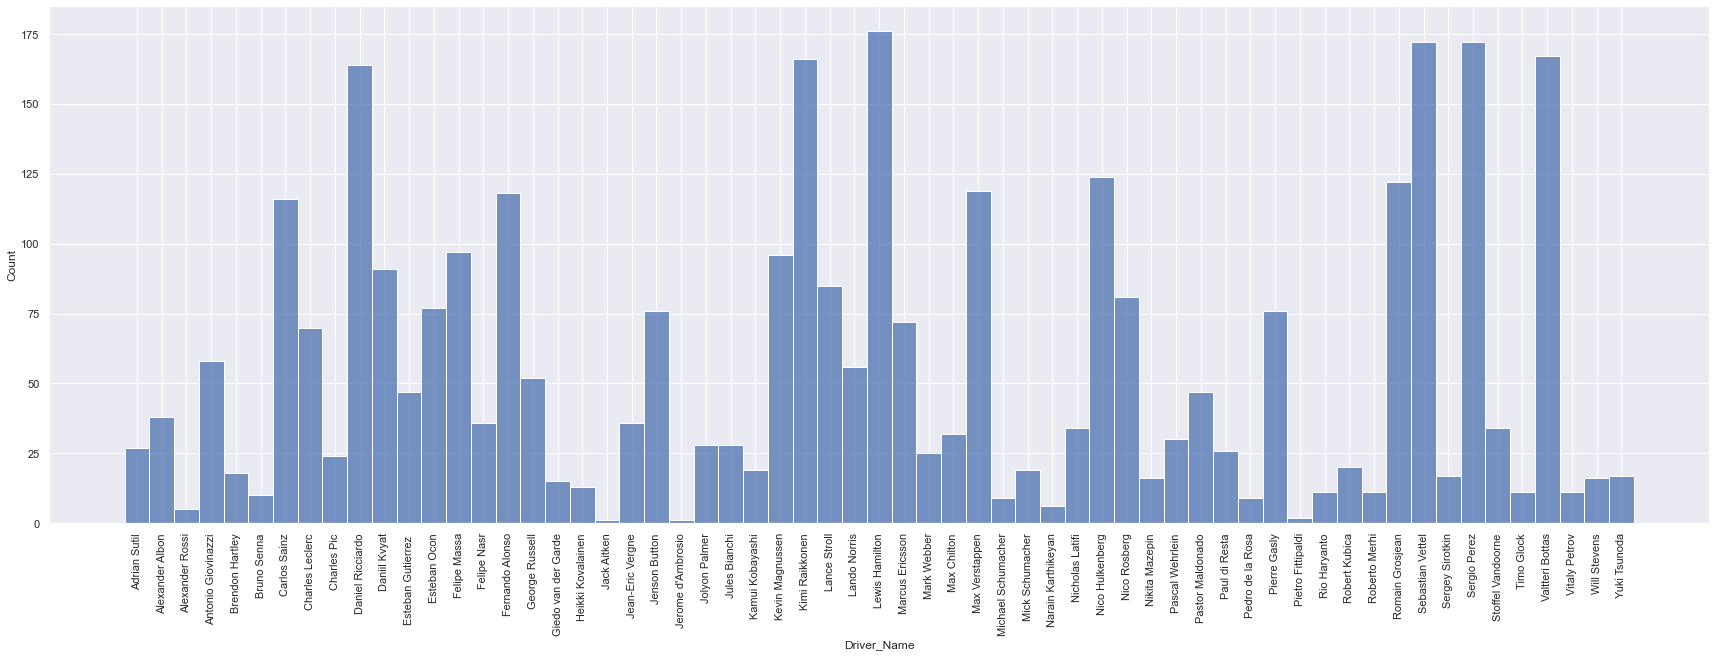

In [74]:
#Distribution of drivers across 2012 - 2021
plt.figure()
ax = sns.displot(cleaned_df.Driver_Name.sort_values(), height=8, aspect=24/8)
plt.xticks(rotation = 90)
# plt.savefig("./driver_distribution.jpg", dpi=1500, bbox_inches='tight')
plt.show()
# Insights: not uniformly distributed, only a few have competed regularly between 2012 - 2021 
# Reasons: retirement from F1, team liquidation, injury/death, new to F1, or simply a bad driver 

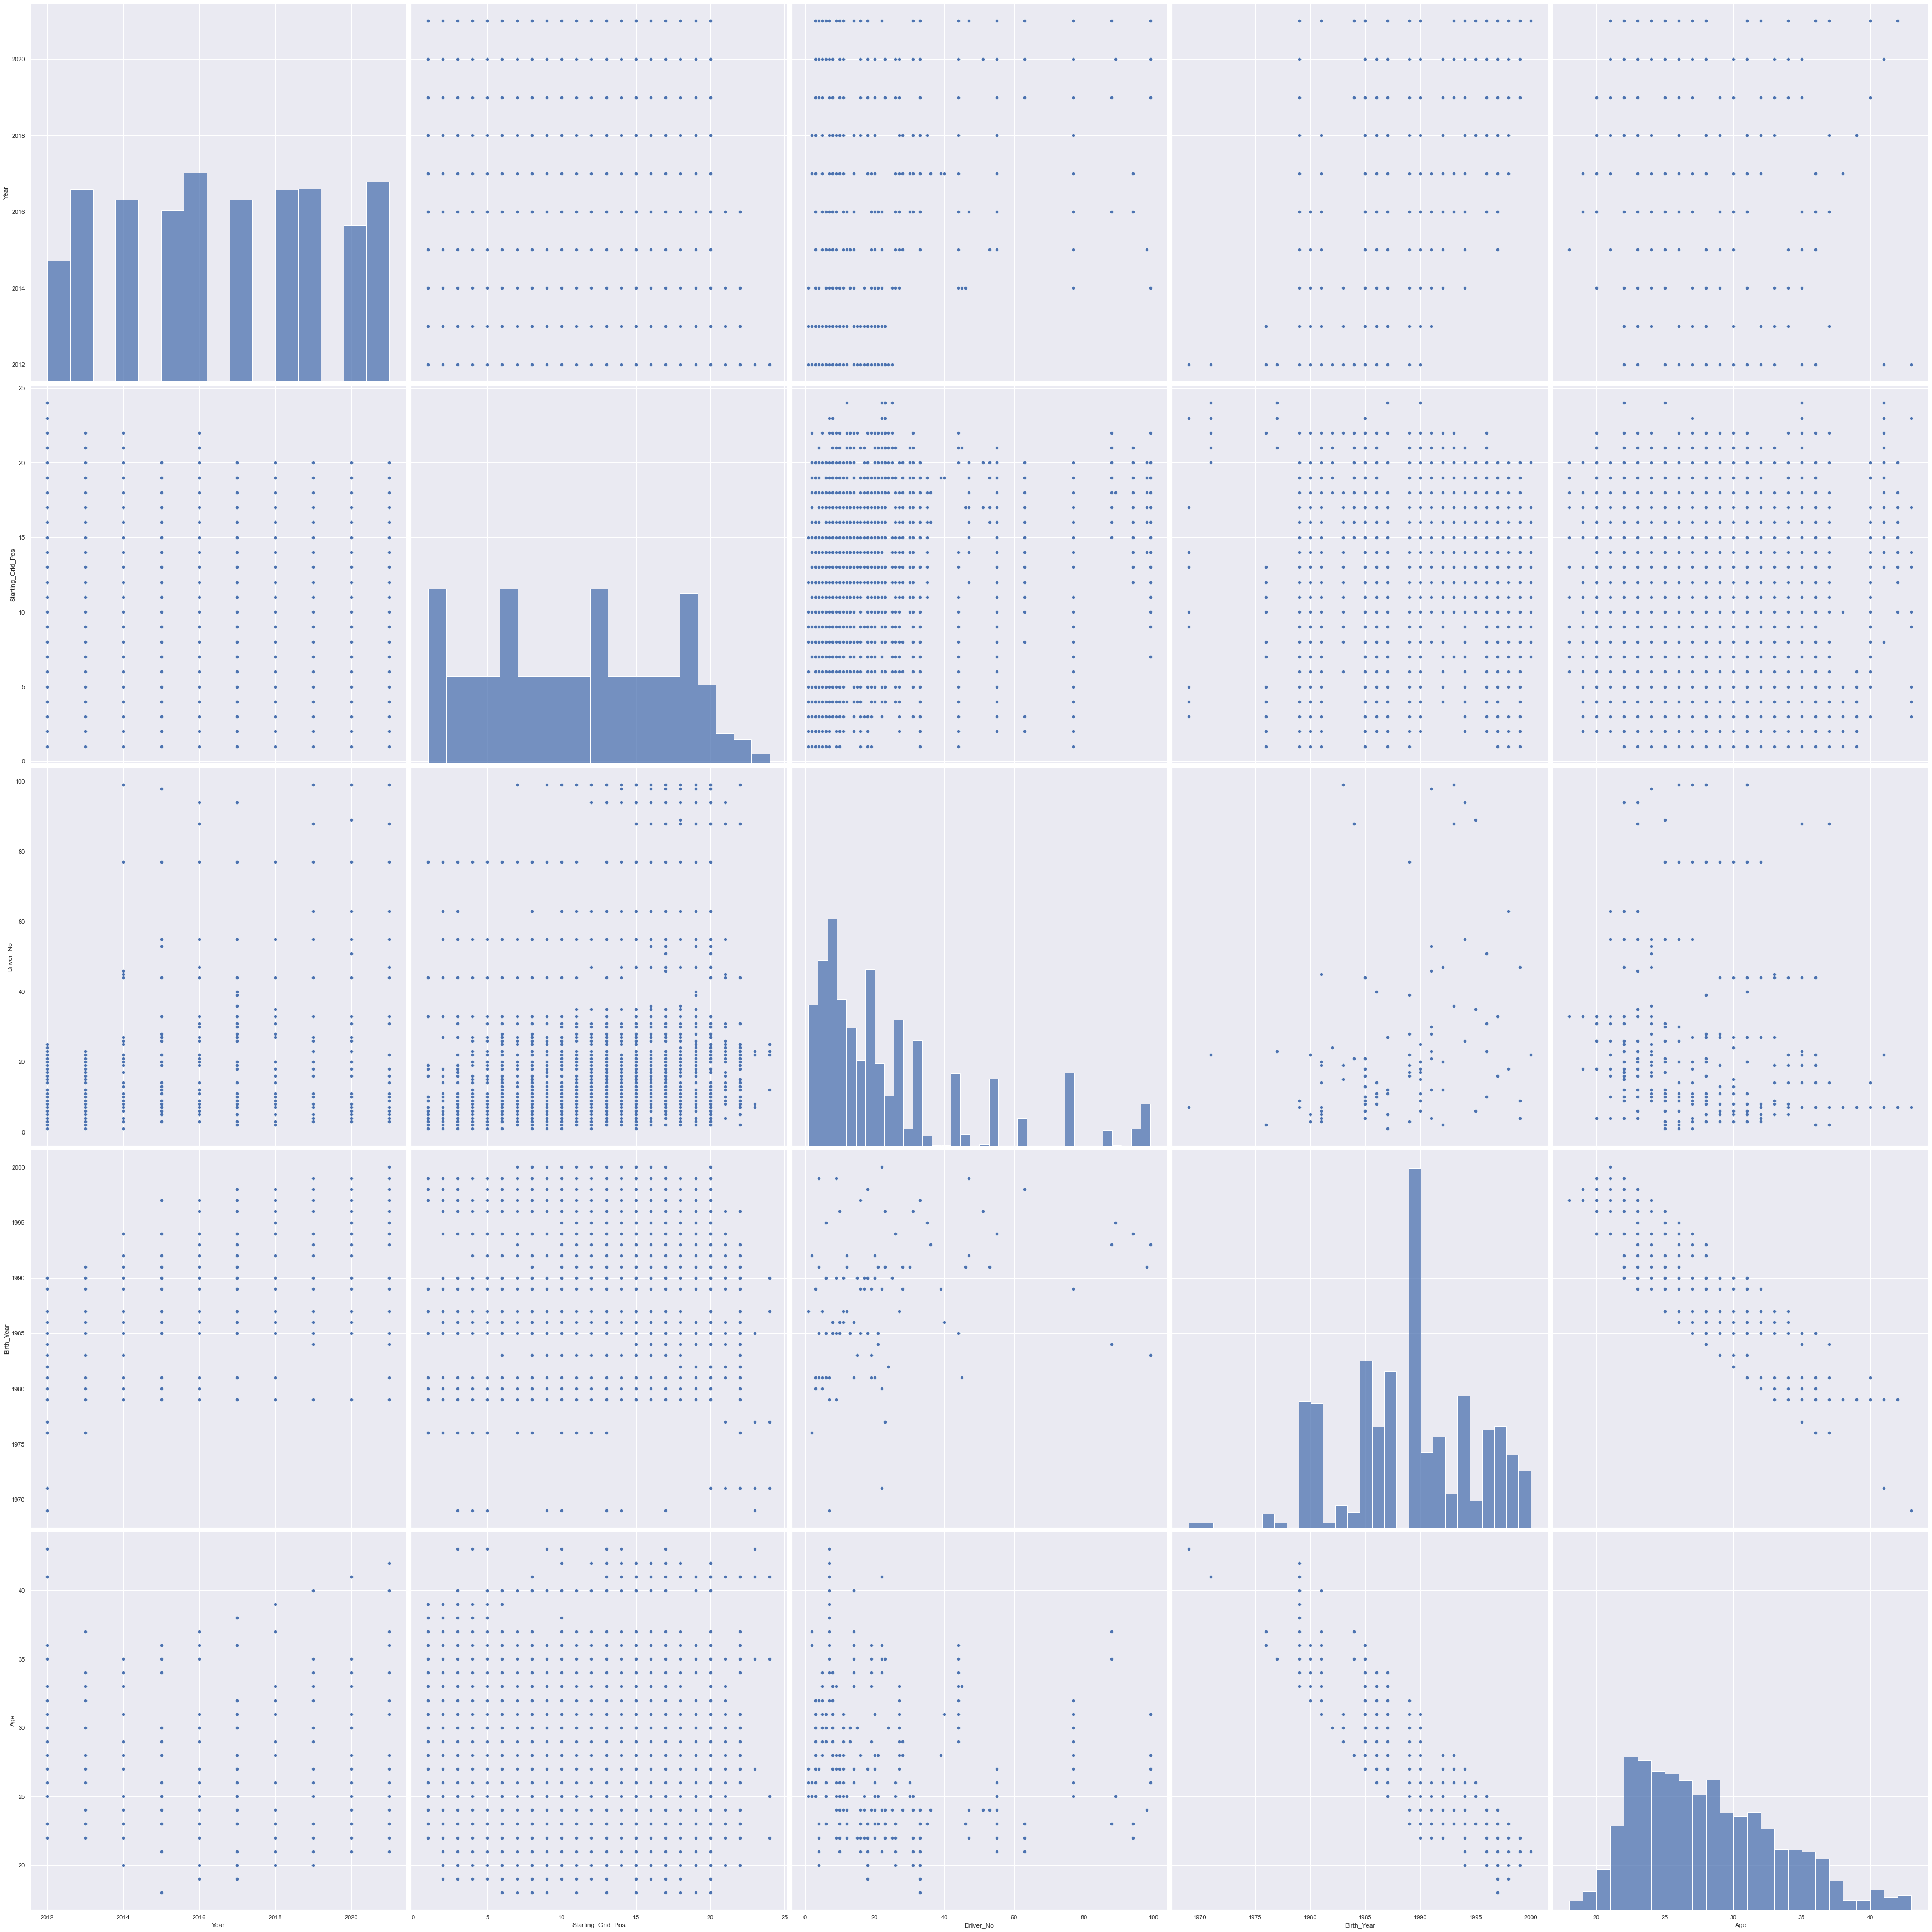

In [51]:
# Seaborn pair plot for data exploration (starting grid)
sns.pairplot(sg_df, height = 10, aspect = 1)

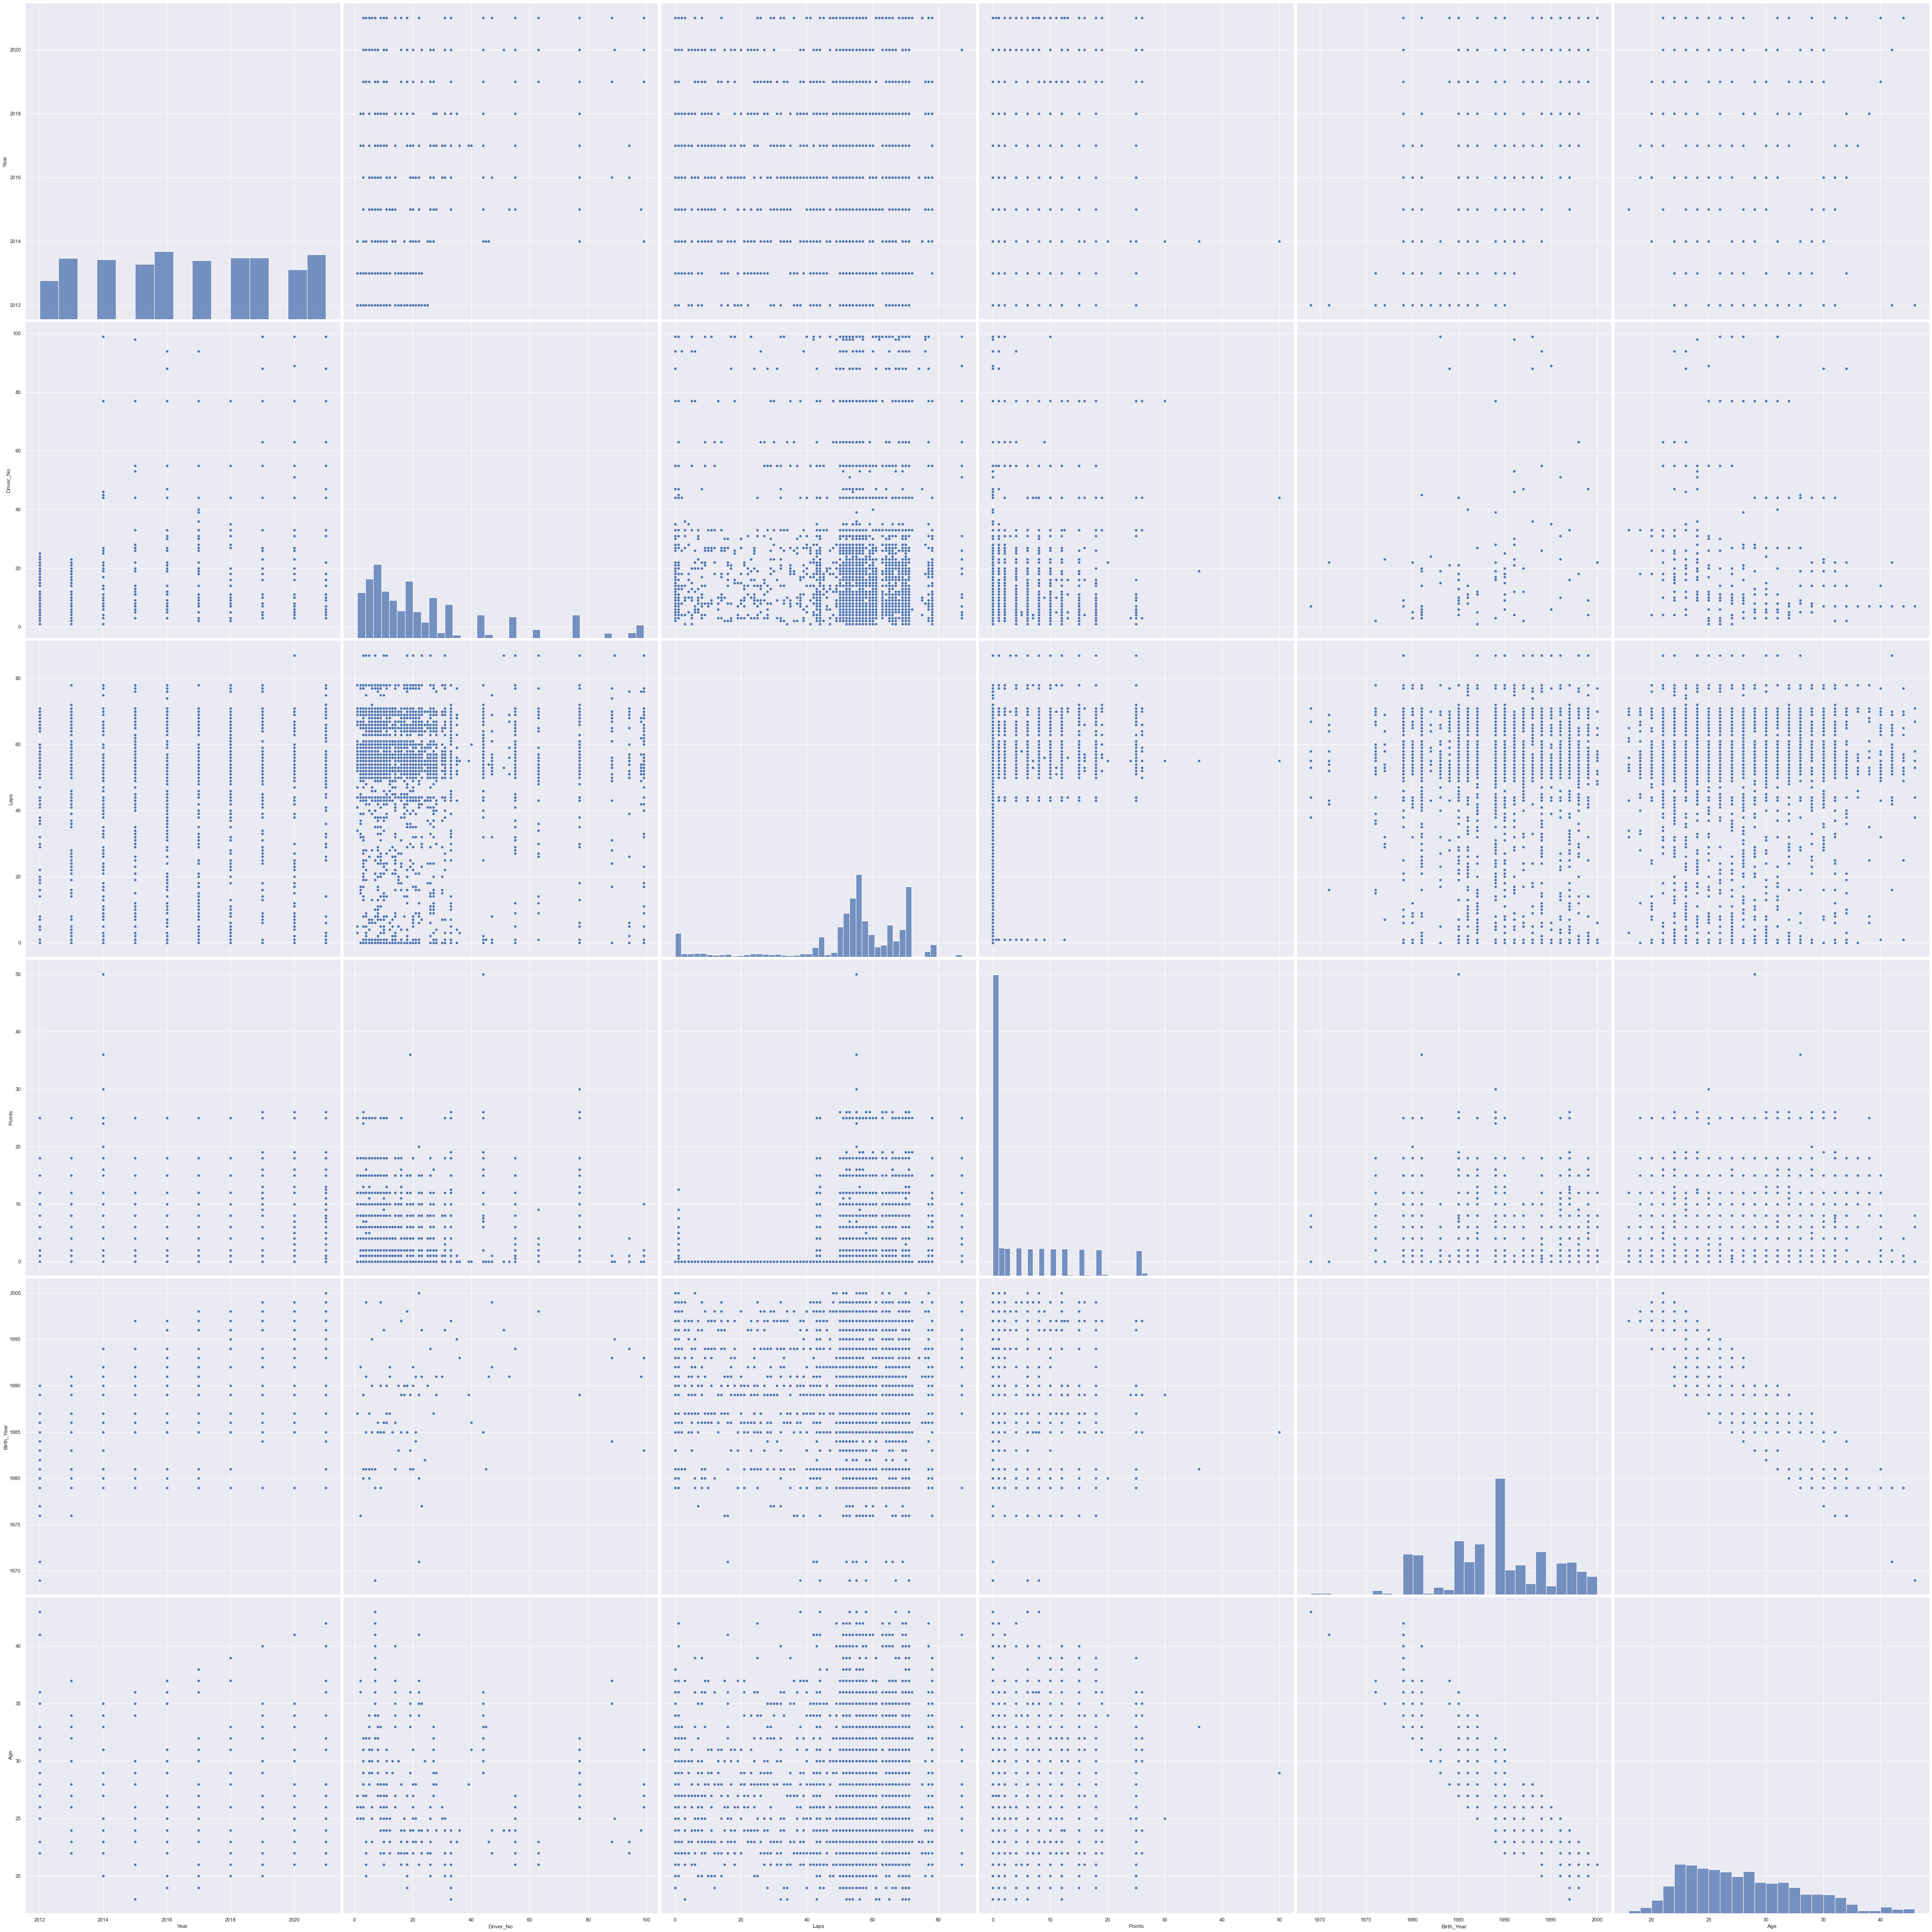

In [52]:
# Seaborn pair plot for data exploration (race result)
sns.pairplot(rr_df, height = 10, aspect = 1)

Text(0.5, 1.0, 'Distribution of Race Result Grid Positions across 2012 to 2021')

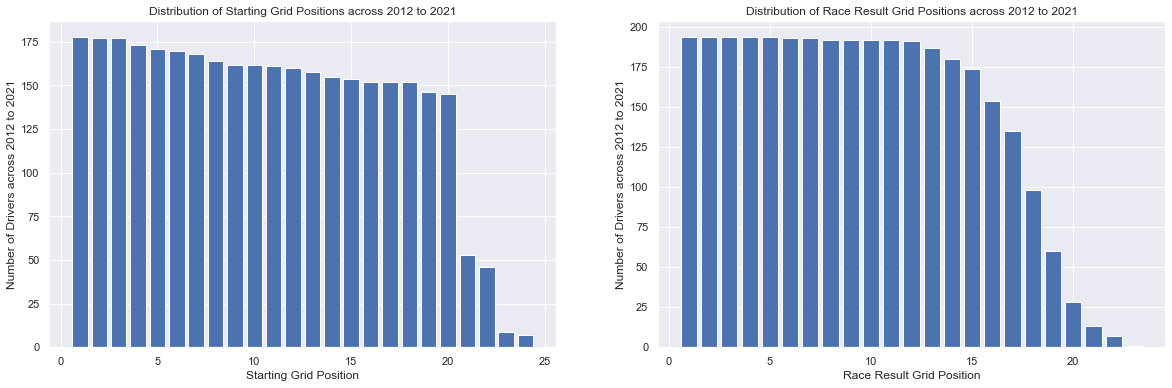

In [53]:
#Check distribution of grid positions for both starting grid and race result - nowadays, there are only 20 positions 
fig, axes = plt.subplots(1, 2, figsize=(20,6))
axes[0].bar(sorted(cleaned_df['Starting_Grid_Pos'].unique()), height= cleaned_df['Starting_Grid_Pos'].value_counts().tolist())
axes[0].set_xlabel('Starting Grid Position')
axes[0].set_ylabel('Number of Drivers across 2012 to 2021')
axes[0].set_title('Distribution of Starting Grid Positions across 2012 to 2021')

axes[1].bar(sorted(cleaned_df['Race_Result_Pos'].unique()), height= cleaned_df['Race_Result_Pos'].value_counts().tolist())
axes[1].set_xlabel('Race Result Grid Position')
axes[1].set_ylabel('Number of Drivers across 2012 to 2021')
axes[1].set_title('Distribution of Race Result Grid Positions across 2012 to 2021')

# Insights: There were a lot of NC (non-classified finish)
# Means car was still running at finishing line, but did not complete number of laps for points finish
# Removing DNF can give a better understanding of the data

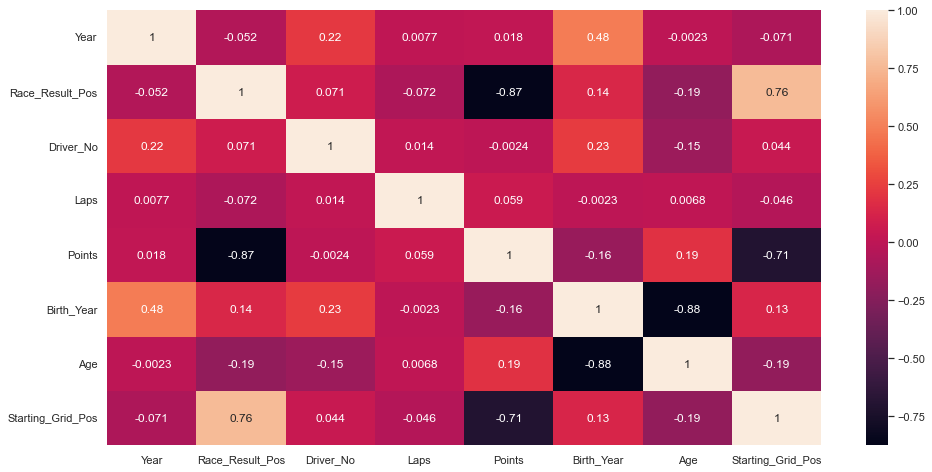

In [55]:
hmap = sns.heatmap(cleaned_df.corr(), annot=True)
fig = hmap.get_figure()
# fig.savefig("./corr_heatmap.png", dpi=720, bbox_inches='tight')
# files.download("corr_heatmap.png") 
# Strong positive correlation between starting grid position and race result position.
# Strong negative correlation between starting grid position and points: implies as starting grid
# position decreases (i.e. lower on the grid), points decrease.
# Strong negative correlation between race result position and points: implies as race result position
# decreases (i.e. you finish closer to last place), that the number of points decrease.

In [56]:
sg_rr_corr = cleaned_df['Starting_Grid_Pos'].corr(cleaned_df['Race_Result_Pos'], method='pearson')
sg_rr_corr

0.7586044422038922

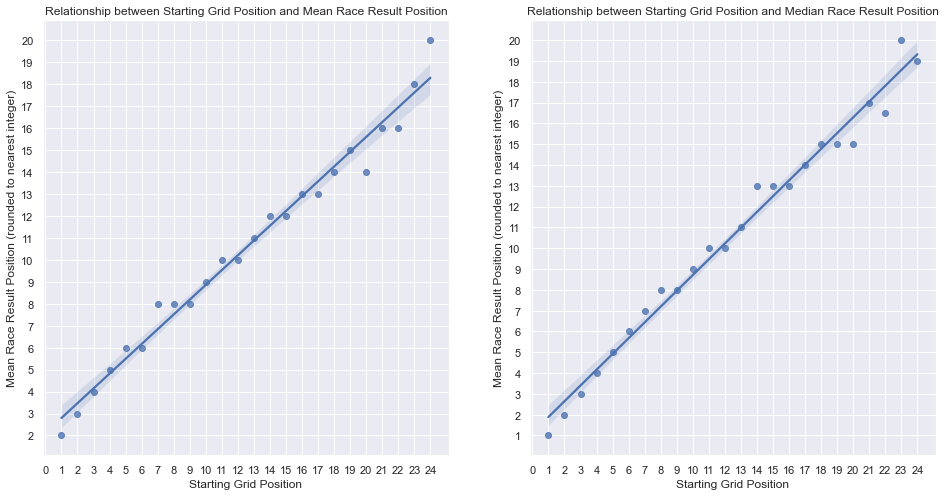

In [59]:
# Mean and Median Race Result Positions for each Starting Position 
fig, axes = plt.subplots(1, 2, figsize=(16,8))
plt.setp(axes, xticks=list(range(0,25)), yticks=list(range(0,21)))
axes[0] = sns.regplot(ax=axes[0], x = sorted(cleaned_df['Starting_Grid_Pos'].unique().tolist()), y=round(cleaned_df.groupby(['Starting_Grid_Pos'])['Race_Result_Pos'].mean()))
axes[0].set_xlabel('Starting Grid Position')
axes[0].set_ylabel('Mean Race Result Position (rounded to nearest integer)')
axes[0].set_title('Relationship between Starting Grid Position and Mean Race Result Position')

axes[1] = sns.regplot(ax=axes[1], x = sorted(cleaned_df['Starting_Grid_Pos'].unique().tolist()), y=cleaned_df.groupby(['Starting_Grid_Pos'])['Race_Result_Pos'].median())
axes[1].set_xlabel('Starting Grid Position')
axes[1].set_ylabel('Mean Race Result Position (rounded to nearest integer)')
axes[1].set_title('Relationship between Starting Grid Position and Median Race Result Position')

# plt.savefig("./rr_vs_sg.png", dpi=720, bbox_inches='tight')
# files.download("rr_vs_sg.png") 
plt.show()
# Quite a strong correlation between the starting position and the final position of the race

<function matplotlib.pyplot.show(close=None, block=None)>

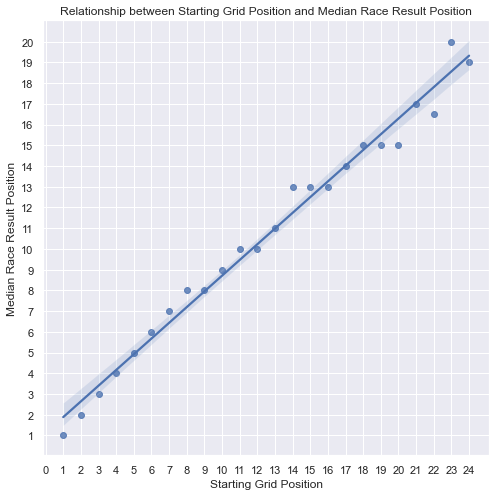

In [75]:
#Median Race Result Positions for each Starting Position 
fig, ax = plt.subplots(figsize=(8,8))
plt.setp(ax, xticks=list(range(0,25)), yticks=list(range(0,21)))
ax = sns.regplot(x = sorted(cleaned_df['Starting_Grid_Pos'].unique().tolist()), y=cleaned_df.groupby(['Starting_Grid_Pos'])['Race_Result_Pos'].median())
ax.set_xlabel('Starting Grid Position')
ax.set_ylabel('Median Race Result Position')
ax.set_title('Relationship between Starting Grid Position and Median Race Result Position')

# plt.savefig("./median_rr_for_sg.jpg", dpi=720, bbox_inches='tight')
plt.show
# Quite a strong correlation between the starting position and the final position of the race

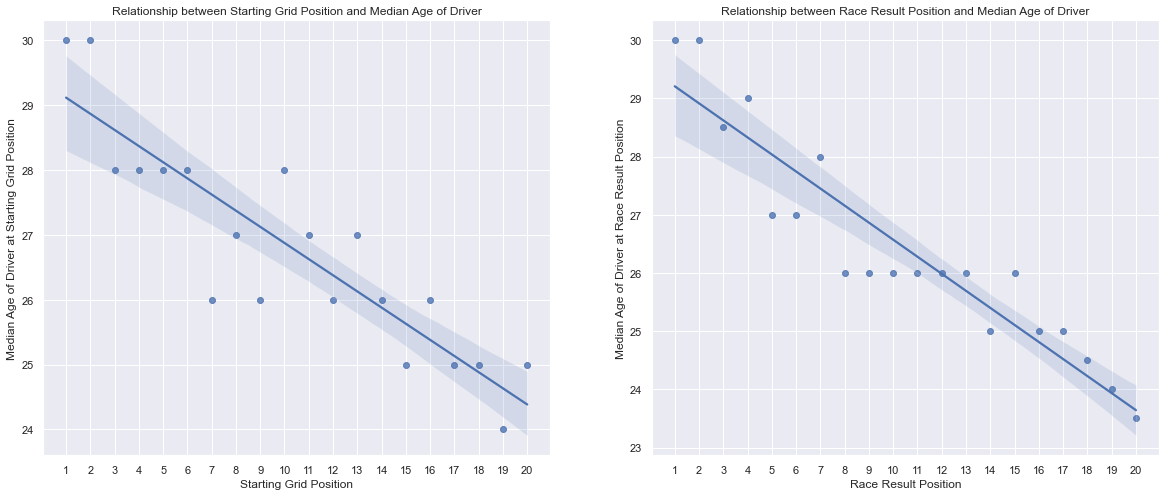

In [60]:
# Grid Position vs. Median Age for each Position (for positions 1 to 20)
fig, axes = plt.subplots(1, 2, figsize=(20,8))
plt.setp(axes, xticks=list(range(1,25)), yticks=list(range(0,45)))
axes[0] = sns.regplot(ax=axes[0], x = sorted(cleaned_df['Starting_Grid_Pos'].unique())[0:20], y=cleaned_df.groupby(['Starting_Grid_Pos'])['Age'].median()[0:20])
axes[0].set_xlabel('Starting Grid Position')
axes[0].set_ylabel('Median Age of Driver at Starting Grid Position')
axes[0].set_title('Relationship between Starting Grid Position and Median Age of Driver')

axes[1] = sns.regplot(ax=axes[1], x = sorted(cleaned_df['Race_Result_Pos'].unique().tolist())[0:20], y=cleaned_df.groupby(['Race_Result_Pos'])['Age'].median()[0:20])
axes[1].set_xlabel('Race Result Position')
axes[1].set_ylabel('Median Age of Driver at Race Result Position')
axes[1].set_title('Relationship between Race Result Position and Median Age of Driver')

# plt.savefig("./age_vs_sg.png", dpi=720, bbox_inches='tight')
# files.download("age_vs_sg.png") 
plt.show()
# Insights: the hotly-debated issue of whether younger drivers perform better than older drivers can be investigated
# through this scatter plot. It seems that for both starting positions and race results, older drivers outperformed 
# youngers drivers (from the races between 2012 - 2021 at least) 

In [61]:
cleaned_df['Pos_Change'] = cleaned_df['Race_Result_Pos'] - cleaned_df['Starting_Grid_Pos']
cleaned_df.head()

,Country,Year,Race_Result_Pos,Driver_No,Driver_Name,Driver_Initials,Car_Name,Laps,Time_or_Retired,Points,Birth_Year,Age,Starting_Grid_Pos,QualifyTime,Pos_Change
0,Germany,2012,1,5,Fernando Alonso,ALO,Ferrari,67,1:31:05.862,25.0,1981,31,1,1:40.621,0
1,Germany,2012,2,3,Jenson Button,BUT,McLaren Mercedes,67,+6.949s,18.0,1980,32,6,1:44.113,-4
2,Germany,2012,3,9,Kimi Raikkonen,RAI,Lotus Renault,67,+16.409s,15.0,1979,33,10,1:45.811,-7
3,Germany,2012,4,14,Kamui Kobayashi,KOB,Sauber Ferrari,67,+21.925s,12.0,1986,26,12,1:39.985,-8
4,Germany,2012,5,1,Sebastian Vettel,VET,Red Bull Racing Renault,67,+23.732s,10.0,1987,25,2,1:41.026,3


Text(0.5, 1.0, 'Median Position per Driver')

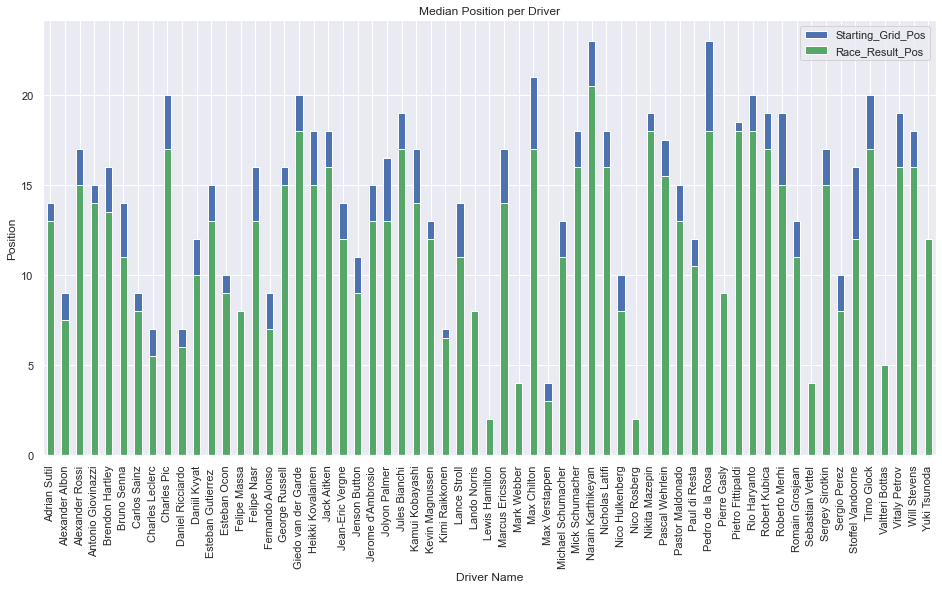

In [64]:
# Starting and Race Result Median Positions
cleaned_df.groupby('Driver_Name')['Starting_Grid_Pos'].median().plot(kind='bar')
cleaned_df.groupby('Driver_Name')['Race_Result_Pos'].median().plot(kind='bar', color='g')
plt.legend()
plt.ylabel('Position')
plt.xlabel('Driver Name')
plt.title('Median Position per Driver')
# plt.savefig('median_pos_driver.png', dpi=720, bbox_inches='tight')
# files.download("median_pos_driver.png") 

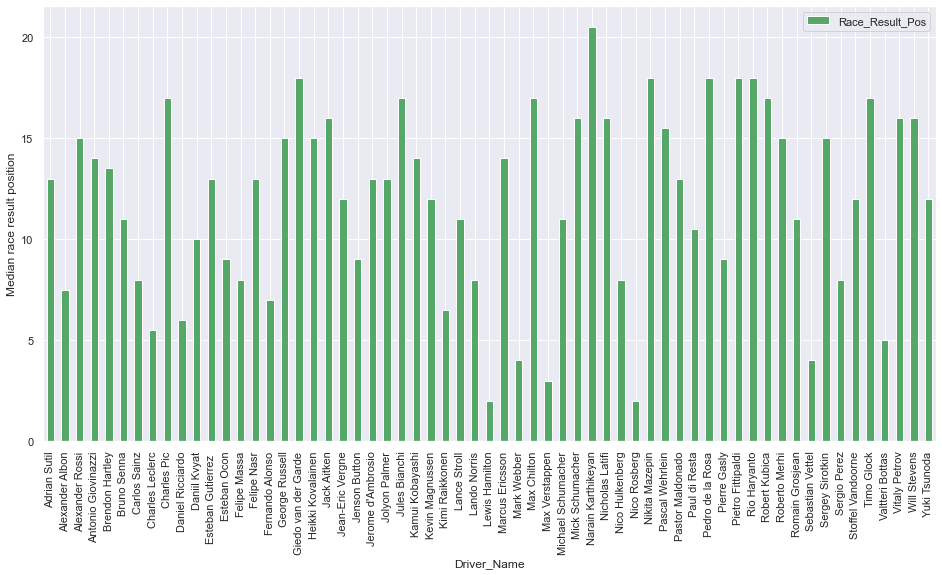

In [80]:
cleaned_df.groupby('Driver_Name')['Race_Result_Pos'].median().plot(kind='bar', color='g')
plt.ylabel('Median race result position')
plt.yticks(list(range(0,21,5)))
plt.legend()
plt.savefig("./driver_rr_pos_median.jpg", dpi=1080, bbox_inches='tight')
plt.show()

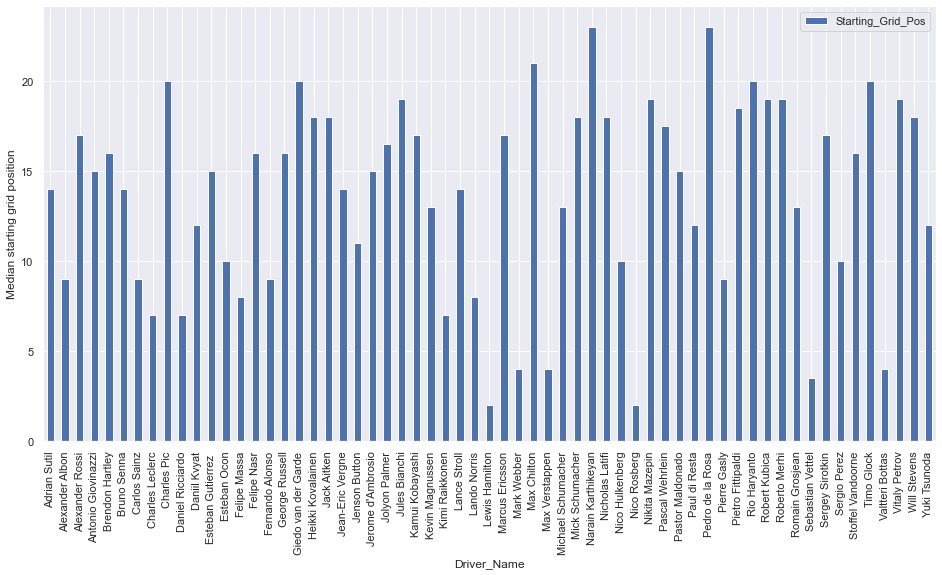

In [67]:
cleaned_df.groupby('Driver_Name')['Starting_Grid_Pos'].median().plot(kind='bar')
plt.ylabel('Median starting grid position')
plt.legend()
# plt.savefig("./driver_sg_pos_median.jpg", dpi=720, bbox_inches='tight')
plt.show()

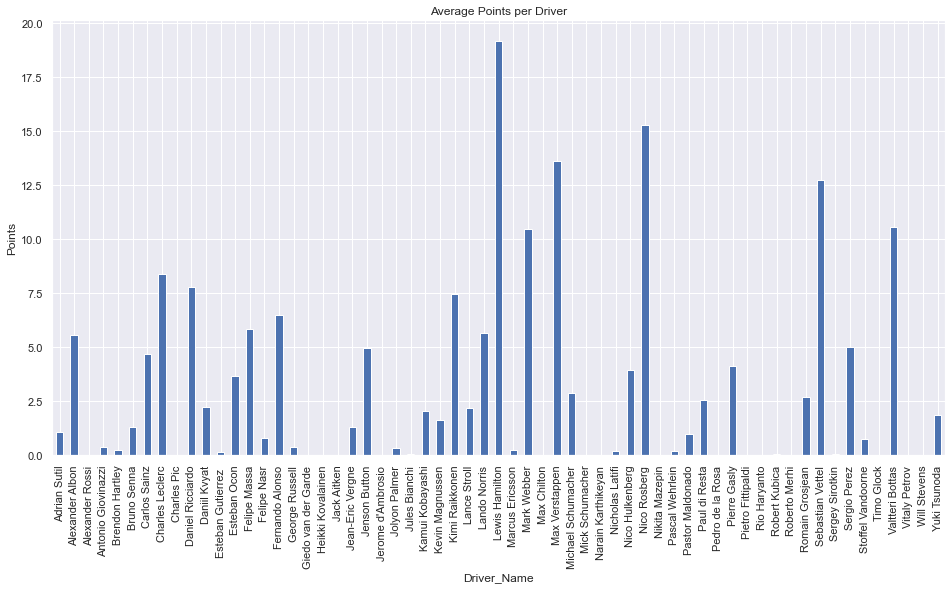

In [68]:
#Average points per driver
cleaned_df.groupby(['Driver_Name'])['Points'].mean().plot(kind='bar')
plt.ylabel('Points')
plt.title('Average Points per Driver')
# plt.savefig("./avg_points_driver.jpg", dpi=720, bbox_inches='tight')
plt.show()

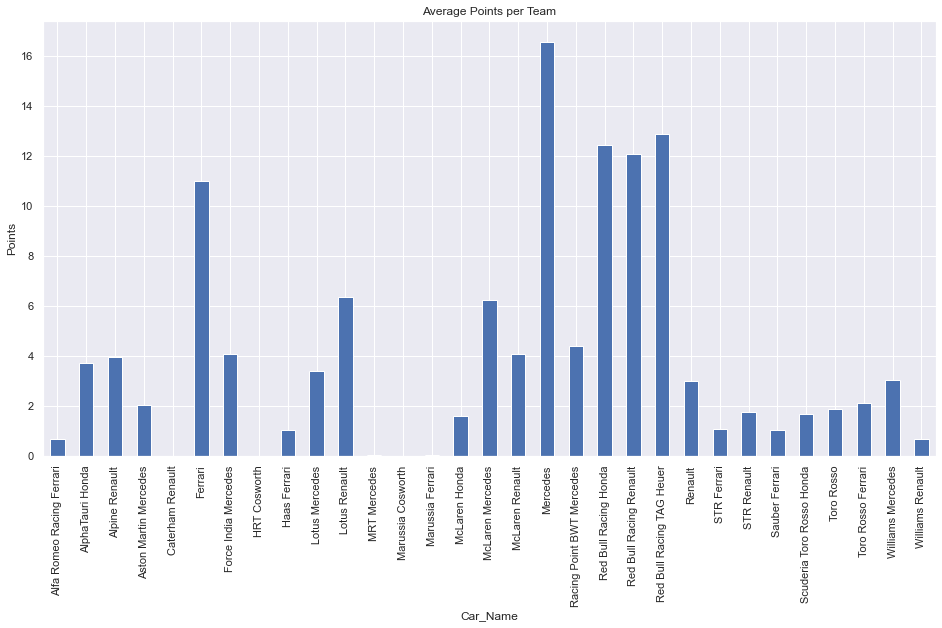

In [76]:
cleaned_df.groupby(['Car_Name'])['Points'].mean().plot(kind='bar')
plt.ylabel('Points')
plt.title('Average Points per Team')
# plt.savefig("./avg_points_team.jpg", dpi=720, bbox_inches='tight')
plt.show()

In [77]:
# merged_df.to_csv("./merged_df.csv", encoding = 'utf-8-sig')
# cleaned_df.to_csv("./cleaned_df.csv", encoding = 'utf-8-sig')